# Import Package

In [2]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
print(f'''
{np.__version__},
{pd.__version__},
{tf.__version__}''')


1.21.6,
1.3.5,
2.8.2


In [5]:
!python --version

Python 3.7.13


# Import Dataset

In [6]:
rating = pd.read_csv('rating_hotel_yogyakarta.csv')
hotel = pd.read_csv('hotel.csv')
user = pd.read_csv('user.csv')

In [7]:
# melihat ukuran data
print(f'rating : {rating.shape}')
print(f'hotel : {hotel.shape}')
print(f'user : {user.shape}')

rating : (10000, 3)
hotel : (110, 11)
user : (300, 3)


# Persiapan Dataset

In [8]:
# Merubah data agar hanya dari Kota Yogyakarta

hotel = hotel[hotel['City']=='Yogyakarta']
hotel.head()

,id,Name,City,Ratings,Price,Addres,Coordinate,Description,Lat,Long,Images
0,1,Artotel Suites Bianti Yogyakarta,Yogyakarta,5.0,625000,"Jl. Urip Sumoharjo No.37, Klitren, Kec. Gondok...","-7.782655534201323, 110.38190546790418",Set among shops in the city center and offerin...,-7.782656,110.381906,https://asset.kompas.com/crops/bcek5vqNPwTfaEL...
1,2,The Phoenix Hotel Yogyakarta - MGallery Collec...,Yogyakarta,4.5,735390,"Jl. Jend. Sudirman No.9, Cokrodiningratan, Kec...","-7.782368072882206, 110.36852501265078","Set in a colonial building dating from 1918, t...",-7.782368,110.368525,https://cf.bstatic.com/xdata/images/hotel/max1...
2,3,Hotel New Saphir Yogyakarta,Yogyakarta,3.5,398160,"Jl. Laksda Adisucipto No.38, Demangan, Kec. Go...","-7.783321134572196, 110.3914155390688","This chic, palm-tree fronted hotel with views ...",-7.783321,110.391415,https://s-light.tiket.photos/t/01E25EBZS3W0FY9...
3,4,Lafayette Boutique Hotel Yogyakarta,Yogyakarta,4.5,649366,"Manggung, Caturtunggal, Kec. Depok, Kabupaten ...","-7.759268574181231, 110.38734472557458","In a bustling commercial area, this upscale, s...",-7.759269,110.387345,https://ik.imagekit.io/tvlk/apr-asset/dgXfoyh2...
4,5,Grand Mercure Yogyakarta Adi Sucipto,Yogyakarta,4.5,532784,"Jl. Laksda Adisucipto No.80, Demangan Baru, Ca...","-7.783529869615401, 110.39236054584215",Set in a commercial area and offering views of...,-7.783530,110.392360,https://cf.bstatic.com/xdata/images/hotel/max1...


In [9]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,29,3
1,1,28,2
2,1,9,5
3,1,30,3
4,1,40,4


In [10]:
df = rating.copy()

In [11]:
#ENCODING
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [12]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [13]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [14]:
# Mendapatkan jumlah user dan hotel
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
# mengubah nilai rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

In [15]:
print(f'Jumlah user : {num_users}')
print(f'Jumlah Hotel : {num_place}')
print(f'Rating minimum : {min_rating}')
print(f'Rating maximum : {max_rating}')

Jumlah user : 300
Jumlah Hotel : 59
Rating minimum : 1.0
Rating maximum : 5.0


In [16]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,10,3.0,187,12
4684,142,9,2.0,141,2
1731,54,51,3.0,53,15
4742,144,31,3.0,143,6
4521,138,53,5.0,137,44


# Splitting Dataset

In [17]:
# Mambuat Variable x
x = df[['user', 'place']].values
# membuat Variable y
y = df['Place_Ratings'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# split dataset
indices = int(0.8*df.shape[0])
x_train, x_test, y_train, y_test = (x[:indices],
                                    x[indices:],
                                    y[:indices],
                                    y[indices:]
                                    )
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (8000, 2)
x_test : (2000, 2)
y_train : (8000,)
y_test : (2000,)


In [18]:
class Recommended(keras.Model):
  def __init__(self,num_users, num_places, embedding_size, **kwargs):
    super(Recommended, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(num_users,
                                           embedding_size,
                                           embeddings_initializer = 'he_normal',
                                           embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users,1)
    self.places_embedding = layers.Embedding(num_places,
                                             embedding_size,
                                             embeddings_initializer='he_normal',
                                             embeddings_regularizer= keras.regularizers.l2(1e-6)
                                             )
    self.places_bias = layers.Embedding(num_places,1)

  def call(self, inputs):
    user_vec = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vec = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vec, places_vec, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)


In [19]:
model = Recommended(num_users, num_place, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# training Model

In [20]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 50,
    validation_data = (x_test, y_test)
)

Epoch 1/50
250/250 [==============================] - 6s 11ms/step - loss: 0.7420 - root_mean_squared_error: 0.3756 - val_loss: 0.7255 - val_root_mean_squared_error: 0.3656
Epoch 2/50
250/250 [==============================] - 1s 4ms/step - loss: 0.7336 - root_mean_squared_error: 0.3705 - val_loss: 0.7240 - val_root_mean_squared_error: 0.3647
Epoch 3/50
250/250 [==============================] - 1s 4ms/step - loss: 0.7297 - root_mean_squared_error: 0.3684 - val_loss: 0.7232 - val_root_mean_squared_error: 0.3643
Epoch 4/50
250/250 [==============================] - 1s 2ms/step - loss: 0.7284 - root_mean_squared_error: 0.3675 - val_loss: 0.7231 - val_root_mean_squared_error: 0.3643
Epoch 5/50
250/250 [==============================] - 1s 2ms/step - loss: 0.7224 - root_mean_squared_error: 0.3640 - val_loss: 0.7235 - val_root_mean_squared_error: 0.3645
Epoch 6/50
250/250 [==============================] - 1s 2ms/step - loss: 0.7209 - root_mean_squared_error: 0.3635 - val_loss: 0.7237 - val

# Evaluasi Model

In [21]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.7080 - root_mean_squared_error: 0.3549


[0.7079681158065796, 0.35488972067832947]

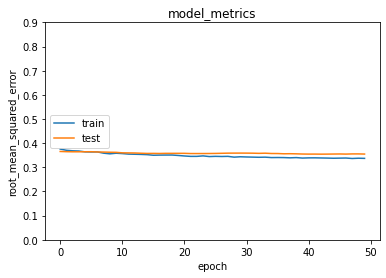

In [23]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.9)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Penerapan Model

In [24]:
hotel.columns

Index(['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images'],
      dtype='object')

In [25]:
place_df = hotel[['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images']]
place_df.columns = ['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images']
df = rating.copy()

In [26]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [27]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited).intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [28]:
# Mengambil top 5 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.Name, '\n    ', row.Addres, ',', 'Harga Tiket Masuk ', row.Price, ',', 'Rating Wisata ', row.Ratings,'\n')

print('==='*15)


------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . Grand Keisha Yogyakarta 
     Jl. Affandi No.9, Gejayan, Condongcatur, Kec. Depok, Kabupaten Sleman, Daerah Istimewa Yogyakarta 55283 , Harga Tiket Masuk  426465 , Rating Wisata  4.5 

2 . H Boutique Hotel Jogjakarta 
     Jl. Prof. Herman Yohanes No.1, Terban, Kec. Gondokusuman, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55223 , Harga Tiket Masuk  293523 , Rating Wisata  4.0 

3 . HOM Premiere Timoho 
     Jl. Ipda Tut Harsono No.24, Muja Muju, Kec. Umbulharjo, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55165 , Harga Tiket Masuk  283433 , Rating Wisata  4.5 

4 . 3C Familia Residence 
     Jalan Mayjend Bambang Sugeng No.949, Bausasran, Kec. Danurejan, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55211 , Harga Tiket Masuk  nan , Rating Wisata  4.2 

5 . Hotel Museum Batik 
     Jl. Doktor Sutomo No.13A, Bausasran, Kec. Danurejan, Ko

# Save Model

In [29]:
model.save_weights('./model_hotel_bali/my_checkpoint')

# Load Model

In [30]:
model_load = Recommended(num_users, num_place, 50)
model_load.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model_load.load_weights('./model_hotel_bali/my_checkpoint')